# Gaussian Mixture Model

The model in this case is $P_{\theta} = \sum_k \pi_k N(\mu_k, \sigma_k^2) = P_G$ where $G=\sum_k \pi_k \delta_{(\mu_k,\sigma_k^2)}$ is the latent mixing measure. Iterativelty, $G$ is estimated via EM algorithm and synthetic samples generated from $P_{\hat{G}}$. Performance is measured by $E[W_1(\hat{G}_t, G_0)]$. 

We take $K=5$ in a 1-dim setup. 

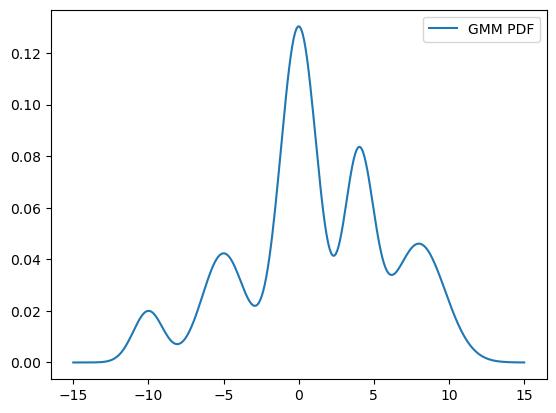

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# true distribution
K = 5
model0 = GaussianMixture(n_components=K)
model0.means_ = np.array([[-10], [-5], [0], [4], [8]])
model0.covariances_ = np.array([[[1.0]], [[2.0]], [[1.5]], [[1.0]], [[3.0]]])
model0.weights_ = np.array([0.05, 0.15, 0.4, 0.2, 0.2])
model0.precisions_cholesky_ = np.sqrt(1/model0.covariances_)

x = np.linspace(-15, 15, 300).reshape((-1,1))
pdf = model0.score_samples(x)
plt.plot(x, np.exp(pdf), label='GMM PDF')
plt.legend()
plt.show()

In [3]:
from sklearn.metrics import pairwise_distances
from ot import emd

def fit(X):
    '''
    X is of shape (n,1)
    '''
    model = GaussianMixture(n_components=K).fit(X)
    return model

def dist(model1, model2):
    '''
    models are GMM objects
    '''
    pi1, mu1, sigma21 = model1.weights_, model1.means_, model1.covariances_.reshape((-1,1))
    pi2, mu2, sigma22 = model2.weights_, model2.means_, model2.covariances_.reshape((-1,1))
    A1 = np.hstack([mu1, sigma21])
    A2 = np.hstack([mu2, sigma22])
    D = pairwise_distances(A1, A2, metric='l1')
    C = emd(pi1, pi2, D)
    return np.sum(C * D)

def plot_avg(loss, ax, plot_traces=True):
    mean = np.mean(loss, axis=0)
    var = np.var(loss, axis=0)
    if plot_traces:
        for i in range(len(loss)):
            ax.plot(range(loss.shape[1]), loss[i], color='yellow', alpha=0.1)
    ax.plot(range(loss.shape[1]), mean)

## Simulation Setups

We conduct 8 experiments:

No fresh data
1. $n_t=50$, $\alpha_t=0$, no accumulation
2. $n_t=50 t$, $\alpha_t=0$, no accumulation
3. $n_t=50 t^{3/2}$, $\alpha_t=0$, no accumulation
4. $n_t=50$, $\alpha_t=0$, accumulation over all past models

Fresh data

5. $n_t=50t$, $\alpha_t=0.1/t$, no accumulation
6. $n_t=50t$, $\alpha_t=0.1/t^{1/2}$, no accumulation
7. $n_t=50t$, $\alpha_t=0.1/t^{1/3}$, no accumulation
7. $n_t=50t$, $\alpha_t=0.1$, no accumulation

In [6]:
n0 = 50

def iterative_GMM(setting, T=100):
    nt_ = setting['nt_'] # n_t = n0 * (1+t)**nt_
    alpha0 = setting['alpha0']
    at_ = setting['at_'] # alpha_t = alpha0 / (1+t)**at_
    accu = setting['accu'] # True or False
    
    # first iteration
    X = model0.sample(n0)[0]
    model = fit(X)

    loss = [dist(model0, model)]
    
    for t in range(T-1):
        n = int(n0 * (1+t)**nt_)
        alpha = alpha0 / (1+t)**at_
        
        if alpha > 0:
            prop = np.array([alpha, 1-alpha])
            m = np.random.multinomial(n, prop)
            if m[0]>0 and m[1]>0:
                X0 = model0.sample(m[0])[0]
                X_ = model.sample(m[1])[0]
                X1 = np.random.permutation(np.vstack([X0, X_]))
            elif m[1]>0:
                X1 = model.sample(m[1])[0]
            elif m[0]>0:
                X1 = model0.sample(m[0])[0]
        else:
            X1 = model.sample(n)[0]
            
        if accu:
            X = np.vstack([X, X1])
            model = fit(X)
        else:
            model = fit(X1)
        loss.append(dist(model0, model))
    return loss

settings = [
    {'nt_': 0, 'alpha0': 0, 'at_': 0, 'accu': False},
    {'nt_': 1, 'alpha0': 0, 'at_': 0, 'accu': False},
    {'nt_': 1.5, 'alpha0': 0, 'at_': 0, 'accu': False},
    {'nt_': 0, 'alpha0': 0, 'at_': 0, 'accu': True},
    {'nt_': 1, 'alpha0': 0.1, 'at_': 1, 'accu': False},
    {'nt_': 1, 'alpha0': 0.1, 'at_': 0.5, 'accu': False},
    {'nt_': 1, 'alpha0': 0.1, 'at_': 0.33, 'accu': False},
    {'nt_': 1, 'alpha0': 0.1, 'at_': 0, 'accu': False}
]

In [7]:
reps = 100
T=200

from tqdm import tqdm
from joblib import Parallel, delayed

losses = np.zeros((len(settings), reps, T))

for i, setting in enumerate(settings):
    results = Parallel(n_jobs=-1)(delayed(iterative_GMM)(setting=setting, T=T) for j in range(reps))
    losses[i] = np.array([results[j] for j in range(reps)])
    print(f'setting {i+1} done')

setting 1 done
setting 2 done
setting 3 done
setting 4 done
setting 5 done
setting 6 done
setting 7 done
setting 8 done


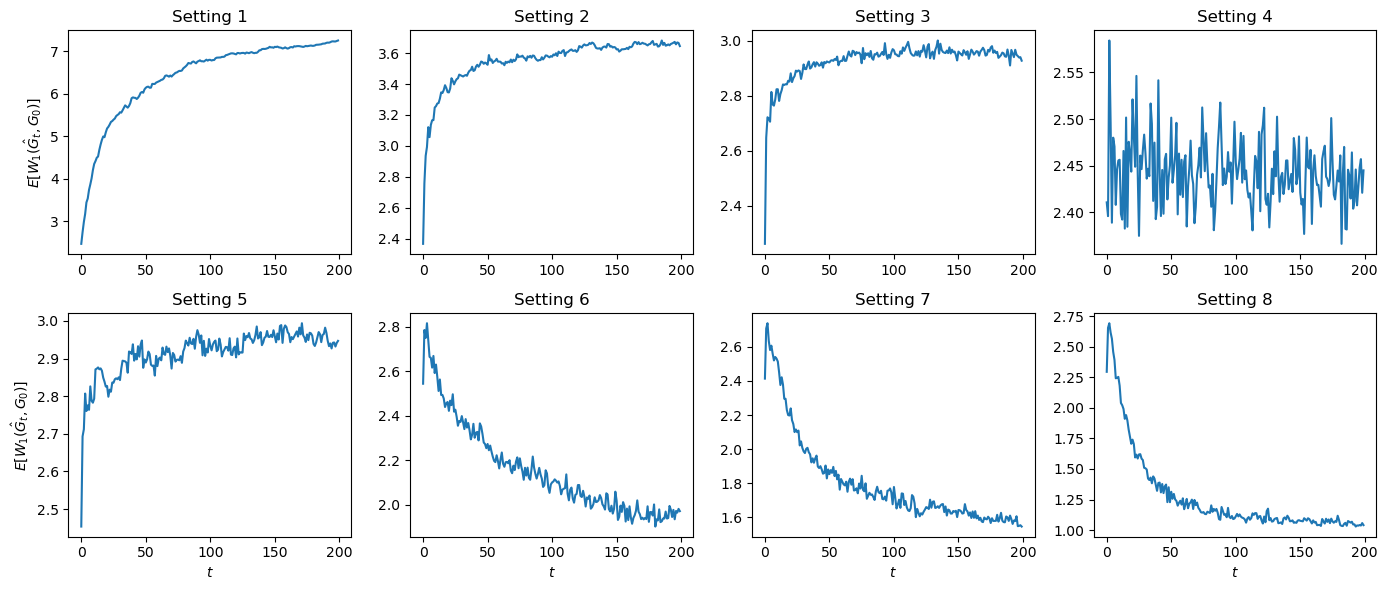

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(14, 6))

for r in range(2):
    for c in range(4):
        plot_avg(losses[4*r+c], ax[r,c], plot_traces=False)
        ax[r,c].set_title(f'Setting {4*r+c+1}')
ax[0,0].set_ylabel('$E[W_1(\hat{G}_t,G_0)]$')
ax[1,0].set_ylabel('$E[W_1(\hat{G}_t,G_0)]$')

for i in range(4):
    ax[1,i].set_xlabel('$t$')
plt.tight_layout()
plt.show()